### Analyzing GPT Categorization
Last modified: 5/2/24 \
Authors: Caroline Jung & Sandy Liu

### Visualizing GPT Categorization

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
dir_path = "/users/carolinejung/CS315-proj3-group2/2-analysis/types-of-video-content/" #CHANGE ME!

In [5]:
category_names = ["civil rights", "culture", "energy and environment", "health, education, and labor",
                  "immigration and international affairs", "housing and social welfare", "defense, law, and crime",
                  "economy, commerce, and transportation", "other"]

female_categories = pd.read_csv(dir_path+"female_categories.csv").drop_duplicates(ignore_index=True)
male_categories = pd.read_csv(dir_path+"male_categories.csv").drop_duplicates(ignore_index=True)

In [12]:
calculate_top_categories(female_categories)

,Description,count,percent
0,other,141,0.321918
1,"health, education, and labor",82,0.187215
2,"defense, law, and crime",71,0.162100
3,"economy, commerce, and transportation",60,0.136986
4,culture,46,0.105023
5,civil rights,43,0.098174
6,immigration and international affairs,18,0.041096
7,energy and environment,18,0.041096
8,housing and social welfare,4,0.009132


In [13]:
def clean_df(df):
    """Given a dataframe of the video ID and its category given by GPT, if a video is classified into two categories,
    then create two rows that share the same video ID but with different categories in each row."""
    new_rows = []
    for person in df.iterrows():
        id = person[1]["video_id"]
        description = person[1]["Description"]

        for category in category_names:
            if category in description:
                new_rows.append({"video_id": id, "Description": category})
    return pd.DataFrame(new_rows)

def calculate_top_categories(df):
    """Given a dataframe of the video ID and its category, output a new dataframe that counts the total number of videos 
    and the percentage of videos in each category"""
    df_counts = clean_df(df)["Description"].value_counts().to_frame().reset_index()
    num_videos = df.shape[0]
    df_counts["percent"] = df_counts.apply(lambda x: x["count"]/num_videos, axis=1)
    return df_counts

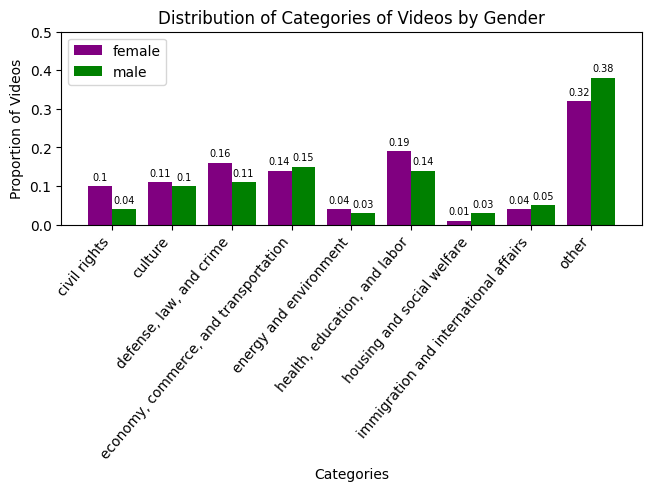

In [98]:
def visualize_categories():
    """Create a side-by-side boxplot visualization of the distribution of categories by gender."""
    output_female = calculate_top_categories(female_categories).sort_values("Description")
    output_male = calculate_top_categories(male_categories).sort_values("Description")
    
    categories = sorted(category_names)
    data = {'female': round(output_female["percent"],2),
            'male': round(output_male["percent"],2)}

    x = np.arange(len(categories))  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0 # to calculate offset
    fig, ax = plt.subplots(layout='constrained')
    for gender, percentages in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, percentages, width, label=gender, color=["purple" if gender == "female" else "green"])
        ax.bar_label(rects, padding=3, size=7)
        multiplier += 1

    ax.set_xticks(x + width/2, categories)
    ax.set_ylim(0, 0.5)
    plt.xticks(rotation=50, ha='right')
    plt.xlabel("Categories")
    plt.ylabel("Proportion of Videos")
    plt.title(f"Distribution of Categories of Videos by Gender")
    plt.legend(loc='upper left')
    plt.show()

visualize_categories()

### Manual checking: Sampling data for manual verification of GPT output
We sample 20% of the videos & their categories from GPT output to manually verify how "correct" its categorization is. The output files for this section are titled `female_manual_verification.csv` and `male_manual_verification.csv`.

In [ ]:
import random

In [86]:
def drop_unmatched_ids(description_df, categories_df):
    """Given two dataframes with the video descriptions and the categories from GPT, drop rows with nonexistent 
    (i.e. the video does not exist on TikTok) video IDs and/or has nonexistent (i.e. NA) categories. Also, drop
    column with the description in a cleaned format for easier reading when manually checking."""

    categories_df.rename(columns={'Description': 'category_gpt'}, inplace=True)
    # filter out categories df that doesn't exist in description df
    mask = ~categories_df['video_id'].isin(description_df['video_id'])
    non_matching_categories = categories_df[mask]

    categories_filtered = categories_df[~categories_df['video_id'].isin(non_matching_categories['video_id'].tolist())]
    merged = pd.merge(categories_filtered, description_df, on='video_id', how='outer')
    without_NAs = merged[~merged['category_gpt'].isna()] #data without NA categories
    return without_NAs.drop(["description_list"], axis=1)

In [87]:
female_description = pd.read_csv("F_all_vid_descriptions_2024_04_29.csv")
male_description = pd.read_csv("M_all_vid_descriptions_2024_04_29.csv")
drop_unmatched_ids(female_description, female_categories)
drop_unmatched_ids(male_description, male_categories)

,video_id,category_gpt,description_string
0,6769961060226075909,other,"hello tiktok, i’m rep. mark takano 👋🏼"
1,6769978510497844485,culture,baking a cake with the sweet feminist ☂️
2,6829721401499421957,"health, education, and labor",$13 billion inrelief funding in theshould be g...
3,6907019172203613446,other,44 + 46 = ❤️
4,6924425222460411141,other,i am running to bein the house of representati...
...,...,...,...
969,7359310165461568798,other,do you know what drives me nuts about what’s g...
970,7359600432097824043,housing and social welfare,we cannot allow the supreme court or local gov...
971,7359609189032824095,"economy, commerce, and transportation",the affordable connectivity program serves ove...
972,7359628313263901995,"defense, law, and crime",here’s a question you don’t hear the corporate...


In [74]:
def sample_videos(merged_df):
    """Given a dataframe of the categories from GPT and the video descriptions, output a 20% sample in a dataframe format."""
    k = int(0.20*merged_df.shape[0]) # sample 20% of the videos
    print("k: ", k)
    indices = random.sample(merged_df.index.to_list(), k) #choose without replacement
    return merged_df[merged_df.index.isin(indices)]

Then, create csvs for manual verification for female and male politicians.

In [72]:
female_description = pd.read_csv("F_all_vid_descriptions_2024_04_29.csv")
female = drop_unmatched_ids(female_description, female_categories)
sample_videos(female).to_csv("female_manual_verification.csv", index=False)

k:  87


In [73]:
male_description = pd.read_csv("M_all_vid_descriptions_2024_04_29.csv")
male = drop_unmatched_ids(male_description, male_categories)
sample_videos(male).to_csv("male_manual_verification.csv", index=False)

k:  189
